<a href="https://colab.research.google.com/github/bchaoss/Fake-News-Detection/blob/main/Fake_News_Detection_with_LSTM_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fake News Detection with LSTM Model in Tensorflow2.x

This notebook mainly focuses on building an LSTM model for fake news detection. It is modified from this great work (https://github.com/matdekoning/FakeNewsClassifier). The model utilizes a dataset available on Kaggle, which can be downloaded from this link: https://www.kaggle.com/c/fake-news/data.

In this work, we leverages the LSTM model to classify news articles and determine their authenticity. LSTM (Long Short-Term Memory) is a type of recurrent neural network that can capture contextual information in text, aiding in better understanding the content and semantics of news articles. By training on a large dataset of real and fake news, the model learns key features to classify new articles.

### Install data from kaggle

In [5]:
# connext kaggle before run this cell
!kaggle competitions download -c fake-news
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt

!unzip /content/competitions/fake-news/fake-news.zip
!unzip /content/datasets/danielwillgeorge/glove6b100dtxt/glove6b100dtxt.zip

 88% 41.0M/46.5M [00:02<00:00, 28.3MB/s]
100% 46.5M/46.5M [00:02<00:00, 21.0MB/s]
 94% 124M/131M [00:01<00:00, 122MB/s]
100% 131M/131M [00:01<00:00, 114MB/s]
Archive:  /content/competitions/fake-news/fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               
Archive:  /content/datasets/danielwillgeorge/glove6b100dtxt/glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

### Prepare the Data

In [7]:
# choose a availble GPU device
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
# read the train/test data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
datasets = [train_df, test_df]

In [9]:
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [11]:
train_df.dropna(subset=['text'], inplace=True)

In [12]:
# Since NaN + string = NaN, we must fill NaN with empty string first.
def get_full_text(df):
    df.fillna('', inplace=True)     # fill NaN
    df['clean_news'] = df['title'] + ' ' + df['text']
    df['clean_news'] = df['clean_news'].str.lower().str.replace('[^A-Za-z0-9\s]', '')
    # no return, change df directly

for df in datasets:
    get_full_text(df)

<ipython-input-12-ce2fd0bd3ef9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_news'] = df['clean_news'].str.lower().str.replace('[^A-Za-z0-9\s]', '')
<ipython-input-12-ce2fd0bd3ef9>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_news'] = df['clean_news'].str.lower().str.replace('[^A-Za-z0-9\s]', '')


In [13]:
train_df.isnull().sum()

id            0
title         0
author        0
text          0
label         0
clean_news    0
dtype: int64

In [14]:
count_empty_strings = len(train_df[train_df['clean_news'] == ' '])
print("number of empty strings：", count_empty_strings)

number of empty strings： 1


In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
def remove_stopwords(df, stop_words):
    df['clean_news'] = df['clean_news'].apply(lambda x:" ".join([word for word in x.split() if word not in stop_words]))

from nltk.corpus import stopwords
stop = stopwords.words('english')
for df in datasets:
    remove_stopwords(df, stop)

In [18]:
# Preprocess train/test data in the same time
def preprocess_data(train_df, test_df, text_column, max_length):
    # merge the text data of the train and test sets
#     all_texts = train_df[text_column].tolist() + test_df[text_column].tolist()
    all_texts = train_df[text_column].tolist()

    # build the Tokenizer
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(all_texts)

    # convert the text data into integer sequences
    train_sequences = tokenizer.texts_to_sequences(train_df[text_column])
    test_sequences = tokenizer.texts_to_sequences(test_df[text_column])

    # perform padding on the sequences, padding to the specified length
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post',truncating='post')
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post',truncating='post')

    return train_padded_sequences, test_padded_sequences, tokenizer

In [19]:
%%time
max_length = 600
train_padded_sequences, test_padded_sequences, tokenizer = preprocess_data(train_df, test_df, 'clean_news', max_length)

# get word index and vocabulary size
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

CPU times: user 11.5 s, sys: 80.4 ms, total: 11.6 s
Wall time: 11.6 s


In [20]:
# get embedding dictionary from glove with dim=100
def get_embedding_dict():
    embedding_dict = {}
    with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_dict[word] = coefs

    return embedding_dict

embedding_dict = get_embedding_dict()

In [21]:
# get embedding martrix for initializing the embedding layer
embedding_dim = 100

def get_embedding_matrix(vocab_size, embedding_dim, word_index, embedding_dict):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = get_embedding_matrix(vocab_size, embedding_dim, word_index, embedding_dict)

In [22]:
# split the train dataset
X_train, X_val, Y_train, Y_val = train_test_split(train_padded_sequences, train_df['label'], test_size=0.2, random_state=42, stratify=train_df['label'])
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((16608, 600), (16608,), (4153, 600), (4153,))

### MODEL

In [24]:
model_lstm = Sequential([
                layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
                layers.Dropout(0.2),
                layers.Conv1D(64, 5, activation='relu'),
                layers.MaxPooling1D(pool_size=4),
                layers.LSTM(32, return_sequences=True),
                layers.LSTM(32),
                # layers.GlobalAveragePooling1D(),
                layers.Dense(128),
                layers.Dense(1, activation='sigmoid')
])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         18842700  
                                                                 
 dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 64)          0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                      

In [25]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [26]:
# convert data to tensor for trainning
X_train_tf = tf.convert_to_tensor(X_train)
Y_train_tf = tf.convert_to_tensor(Y_train)
X_val_tf = tf.convert_to_tensor(X_val)
Y_val_tf = tf.convert_to_tensor(Y_val)

# trainning on GPU
with tf.device('/GPU:0'):
    history1 = model_lstm.fit(X_train_tf, Y_train_tf, epochs=8, batch_size=100, validation_data=(X_val_tf, Y_val_tf))

Epoch 1/8
167/167 [==============================] - 19s 25ms/step - loss: 0.5281 - accuracy: 0.7410 - val_loss: 0.3763 - val_accuracy: 0.8375
Epoch 2/8
167/167 [==============================] - 3s 17ms/step - loss: 0.3031 - accuracy: 0.8754 - val_loss: 0.2383 - val_accuracy: 0.9085
Epoch 3/8
167/167 [==============================] - 3s 17ms/step - loss: 0.2042 - accuracy: 0.9225 - val_loss: 0.1912 - val_accuracy: 0.9294
Epoch 4/8
167/167 [==============================] - 3s 17ms/step - loss: 0.1256 - accuracy: 0.9555 - val_loss: 0.1121 - val_accuracy: 0.9624
Epoch 5/8
167/167 [==============================] - 3s 20ms/step - loss: 0.0836 - accuracy: 0.9721 - val_loss: 0.0884 - val_accuracy: 0.9656
Epoch 6/8
167/167 [==============================] - 3s 17ms/step - loss: 0.0639 - accuracy: 0.9790 - val_loss: 0.1159 - val_accuracy: 0.9653
Epoch 7/8
167/167 [==============================] - 3s 17ms/step - loss: 0.0565 - accuracy: 0.9819 - val_loss: 0.0969 - val_accuracy: 0.9757
Epoch

### Trainning Result:

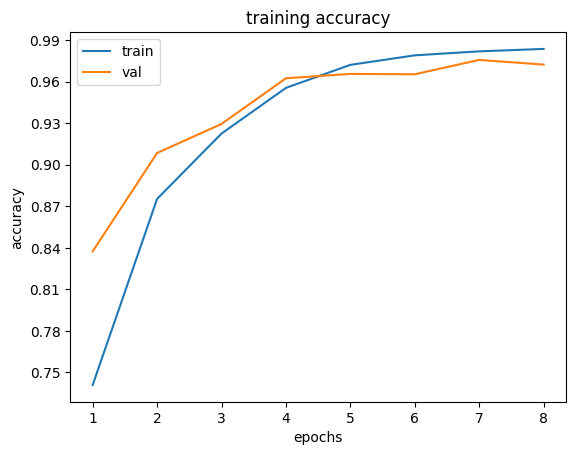

In [27]:
def plot_trainning_result(mode='accuracy'):
    epochs_num = len(history1.history[f'{mode}'])
    plt.plot(history1.history[f'{mode}'])
    plt.plot(history1.history[f'val_{mode}'])
    plt.xlabel('epochs')
    plt.ylabel(f'{mode}')
    plt.legend(['train', 'val'])
    plt.title(f'training {mode}')

    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xticks(list(range(epochs_num)), list(range(1, epochs_num+1)))

    plt.show()

plot_trainning_result('accuracy')

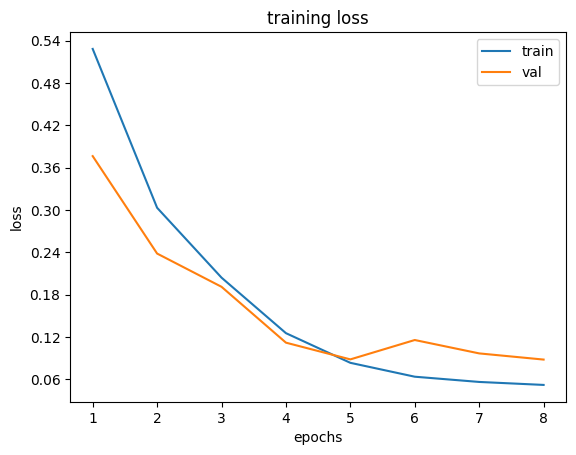

In [28]:
plot_trainning_result('loss')

### Predicting

In [29]:
test_pred = model_lstm.predict(test_padded_sequences, batch_size=64, verbose=1)

82/82 [==============================] - 1s 8ms/step


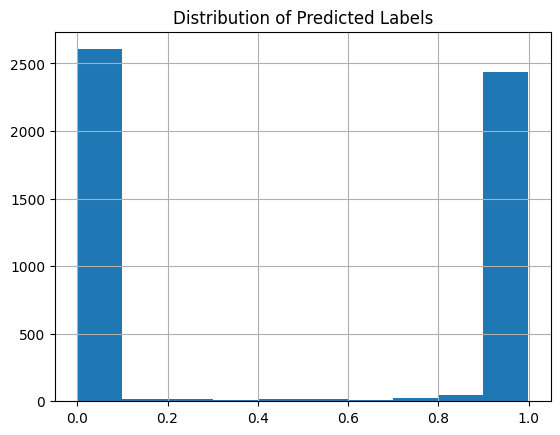

In [30]:
test_df = pd.DataFrame({'id': test_df['id'].to_list(), 'label': test_pred.reshape((5200,))})

test_df['label'].hist()
plt.title('Distribution of Predicted Labels') # due to sigmoid function
plt.show()

In [31]:
# classifier
threshold = 0.5
test_df['label'] = np.where(test_df['label'] >= threshold, 1, 0)
test_df['label'].value_counts()

0    2665
1    2535
Name: label, dtype: int64

## Evaluation

In [60]:
predictions = model_lstm.predict(train_padded_sequences, batch_size=64, verbose=1)

pred_df = pd.DataFrame({'label': predictions.reshape((len(predictions),))})

threshold = 0.5
pred_df['label'] = np.where(pred_df['label'] >= threshold, 1, 0)
pred_df['label'].value_counts()

325/325 [==============================] - 2s 7ms/step


0    10485
1    10276
Name: label, dtype: int64

In [61]:
true_labels = train_df['label']

cm = confusion_matrix(true_labels, pred_df['label'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10312    75]
 [  173 10201]]


In [62]:
f1 = f1_score(true_labels, pred_df['label'])
print("F1 Score:", f1)

F1 Score: 0.9879903147699757
